In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

from plot_settings import *
# Load data from files

PATH = "../benchmarks/mcmc_pi/data/"


data = pd.DataFrame(columns=["trials","method", "parallel", "time"])

for file in os.listdir(PATH):

    # Get num parrallel cores and 
    # num samples from file name:
    # times_dask_trials-[n]_parallel-[m].txt

    trials = file.split("_")[2].split("-")[1]
    parallel = file.split("_")[3].split("-")[1].split(".")[0]
    method = file.split("_")[1]

    # Load data (txt file with one number on each line)
    np_data = np.loadtxt(PATH + file)
    # Reshape to 1d
    np_data = np_data.reshape(-1)

    pd_data = pd.DataFrame(np_data, columns=["time"])
    pd_data["trials"] = trials
    pd_data["parallel"] = parallel
    pd_data["method"] = method
    # concat data
    data = pd.concat([data, pd_data], ignore_index=True)


# Set index
data["trials"] = data["trials"].astype(int)
data["parallel"] = data["parallel"].astype(int)
data["time"] = data["time"].astype(float)
data = data.set_index(["trials", "parallel", "method"])


/tmp/ipykernel_238766/3428655180.py:25: UserWarning: loadtxt: input contained no data: "../benchmarks/mcmc_pi/data/times_dask_trial-100000000000000_parallel-192.txt"
  np_data = np.loadtxt(PATH + file)
/tmp/ipykernel_238766/3428655180.py:25: UserWarning: loadtxt: input contained no data: "../benchmarks/mcmc_pi/data/times_numpy_trials-100000000000_parallel-32.txt"
  np_data = np.loadtxt(PATH + file)
/tmp/ipykernel_238766/3428655180.py:25: UserWarning: loadtxt: input contained no data: "../benchmarks/mcmc_pi/data/times_dask_trial-10000000000000_parallel-96.txt"
  np_data = np.loadtxt(PATH + file)


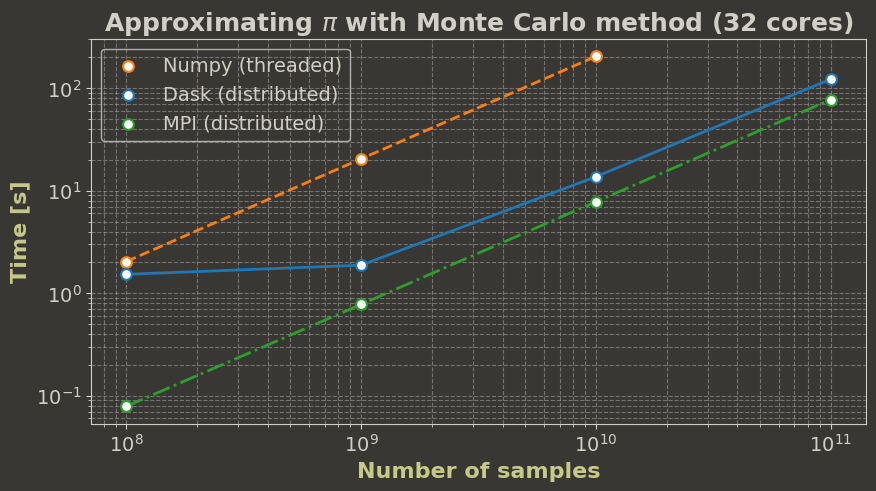

In [3]:
# Create plot
fig, ax = plt.subplots(1,1, figsize=(10,5))

cmap = plt.get_cmap("tab10")

# Set Some plot settings
labels = {"dask":"Dask (distributed)", "numpy":"Numpy (threaded)", "mkl":"MPI (distributed)"}
styles = {"dask":"-", "numpy":"--", "mkl":"-."}
colors = {"dask":cmap(0), "numpy":cmap(1), "mkl":cmap(2)}


for method in ["numpy", "dask", "mkl"]:
    df = data.loc[:,32, method].groupby("trials").mean()
    ax.plot(df.index, df.values, color=colors[method], ls=styles[method])
    ax.scatter(df.index, df.values, 
        marker="o",
        s=60,
        c="white",
        zorder=10,
        label=labels[method],
        edgecolor=colors[method],
        linewidth=1.5)


ax.set_ylabel("Time [s]")

ax.set_xlabel("Number of samples")

# Set formatter for x axis in power two steps ie. 2^8, 2^9, 2^10, ...
from matplotlib.ticker import MultipleLocator

# Remove scientific notation
ax.ticklabel_format(style='plain', axis='x')

# Set lims

# Set power law axis
# Draw grid
ax.grid(True, which="both", ls="--", alpha=0.5)

# Set ticks at multiples of 2

# Disable scientific notation
ax.ticklabel_format(style='plain', axis='x')

ax.set_xscale("log")
ax.set_yscale("log")

ax.legend(loc="upper left")

ax.set_title("Approximating $\pi$ with Monte Carlo method (32 cores)")

save_kwargs = {"bbox_inches":"tight", "dpi":300, "transparent":True}
fig.savefig("../figures/approximating_pi_32_cores.png", **save_kwargs)

## Scaling of the different methods for the pi problem

In [4]:
data_cores = pd.DataFrame(columns=["cores", "time", "method"])

for method in ["numpy", "dask", "mkl"]:
    for parallel in [32 ,64, 96, 128, 160 ]:
        if parallel != 32 and method == "numpy":
            continue

        # Get data
        df = data.loc[:, parallel, method].groupby("trials").mean()
        df = df.reset_index()
        # Drop 100000000
        df = df[df["trials"] != 100000000]


        # Normalize by trials
        df["time"] = df["time"] / df["trials"] * 1e9


        # Add to data_cores
        pd_data = pd.DataFrame(df["time"].values, columns=["time"])
        pd_data["cores"] = parallel
        pd_data["method"] = method
        data_cores = pd.concat([data_cores, pd_data], ignore_index=True)

data_cores.set_index(["cores", "method"], inplace=True)

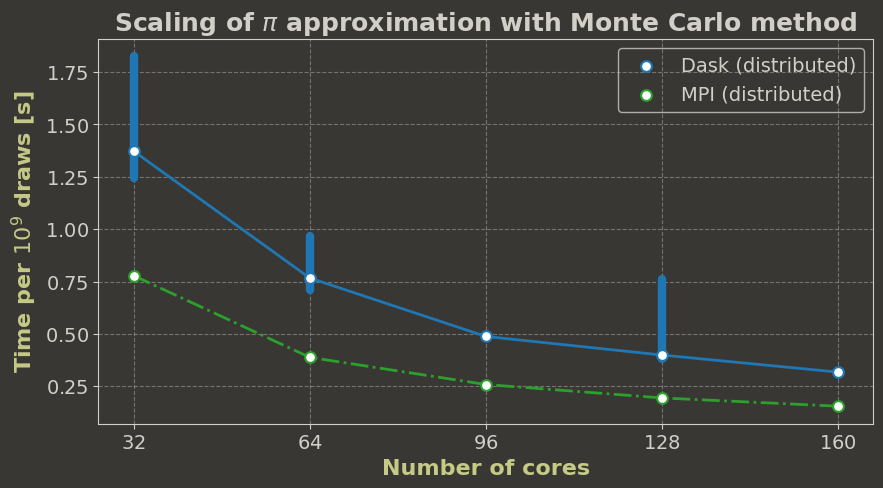

In [6]:
# Create plot
fig, ax = plt.subplots(1,1, figsize=(10,5))

cmap = plt.get_cmap("tab10")

# Plot the different draws per 1000 samples
y = data_cores.groupby(['method',"cores"]).quantile([0.05, 0.5, 0.95])

# Plot
for method in ["dask", "mkl"]:
    temp = y.loc[method,:,0.05]

    lower = y.loc[method,:,0.05]
    upper = y.loc[method,:,0.95]
    lines = ax.vlines(
        x= temp.index,
        ymin=lower,
        ymax=upper,
        color=colors[method],
        ls="-",
        lw=6
    )
    lines.set_capstyle("round")

    ax.scatter(
        x=temp.index,
        y=y.loc[method,:,0.5], 
        marker="o",
        s=60,
        c="white",
        zorder=10,
        label=labels[method],
        edgecolor=colors[method],
        linewidth=1.5
    )

    ax.plot(
        temp.index,
        y.loc[method,:,0.5],
        color=colors[method],
        ls=styles[method],
        lw=2,
    )


# Connect the dots

# set log scale
#ax.set_yscale("log")

# Set grid
ax.grid(True, which="both", ls="--", alpha=0.5)

# Set x position of labels
ax.set_xticks([32, 64, 96, 128, 160])

# Disable scientific notation
ax.ticklabel_format(style='plain', axis='x')

# Set labels
ax.set_ylabel("Time per $10^9$ draws [s]")

ax.set_xlabel("Number of cores")

ax.legend(loc="upper right")

ax.set_title("Scaling of $\pi$ approximation with Monte Carlo method")


save_kwargs = {"bbox_inches":"tight", "dpi":300, "transparent":True}
fig.savefig("../figures/approximating_pi_scaling.png", **save_kwargs)
